In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

# Dandelion example

In [3]:
net = Network(100, 10, edge_weight="normal")

In [4]:
dp = DandelionProtocol(net, 0.5)

nx.draw(dp.line_graph, node_size=20)

In [5]:
%%time
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run(coverage_threshold=0.95)

CPU times: user 221 ms, sys: 3.91 ms, total: 225 ms
Wall time: 223 ms


In [6]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.0, 'inverse_rank': 0.06749927064753902, 'entropy': 0.0, 'ndcg': 0.23125573292390875, 'message_spread_ratio': 0.8390000000000001}
CPU times: user 10.9 ms, sys: 2.42 ms, total: 13.3 ms
Wall time: 9.86 ms


In [7]:
%%time
evaluator = Evaluator(sim, "shortest_path")
print(evaluator.get_report())

{'estimator': 'shortest_path', 'hit_ratio': 0.0, 'inverse_rank': 0.071991391133806, 'entropy': 4.380685781615279, 'ndcg': 0.23864975663228843, 'message_spread_ratio': 0.8390000000000001}
CPU times: user 16.2 ms, sys: 86 µs, total: 16.3 ms
Wall time: 15.9 ms


In [8]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.10648088916287132, 'entropy': 4.499809670330267, 'ndcg': 0.2660401884862127, 'message_spread_ratio': 0.8390000000000001}
CPU times: user 12.5 ms, sys: 589 µs, total: 13.1 ms
Wall time: 11.6 ms


# Experiment example

In [9]:
network_size = 1000
num_msg = 30
degree = 50
num_trials = 5
adversary_ratios = [0.01,0.05,0.1]
results = []

In [10]:
from tqdm.notebook import tqdm

In [11]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, num_msg, verbose=False)
    sim.run(coverage_threshold=1.0)
    reports = []
    for estimator in ["first_reach","first_sent"]:
        evaluator = Evaluator(sim, estimator)
        report = evaluator.get_report()
        report["protocol"] = str(protocol)
        report["adversary_ratio"] = adv.ratio
        reports.append(report)
    return reports, sim

### Simulation running time notes:
- became twice as slower.... :( after not sending event to node who has already boradcasted...
- become much faster after sending only to random sqrt neighbors
- running time scales linearly with number of messages... OK

**After several improvements: 27 sec for three protocols below (only one trial, 30 msg/simulation)**

In [12]:
%%time
# it could be parallelized
for adv_ratio in adversary_ratios:
    for _ in tqdm(range(num_trials)):
        # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
        net = Network(network_size, degree, edge_weight="normal")
        adv = Adversary(net, adv_ratio)
        # BUT: messages won't be the same!!!
        protocols = [
            BroadcastProtocol(net, broadcast_mode="sqrt"),
            DandelionProtocol(net, 0.5),
            DandelionProtocol(net, 0.25)
        ]
        for protocol in protocols:
            new_reports, sim = run_and_eval(net, adv, protocol)
            results += new_reports
    print(adv_ratio)

  0%|          | 0/5 [00:00<?, ?it/s]

0.01


  0%|          | 0/5 [00:00<?, ?it/s]

0.05


  0%|          | 0/5 [00:00<?, ?it/s]

0.1
CPU times: user 6min 51s, sys: 6.06 s, total: 6min 57s
Wall time: 6min 53s


In [13]:
import seaborn as sns

In [14]:
results_df = pd.DataFrame(results)
results_df.head()

,estimator,hit_ratio,inverse_rank,entropy,ndcg,message_spread_ratio,protocol,adversary_ratio
0,first_reach,0.133333,0.138150,0.0,0.240578,0.745933,BroadcastProtocol(broadcast_mode=sqrt),0.01
1,first_sent,0.133333,0.138151,0.0,0.240583,0.745933,BroadcastProtocol(broadcast_mode=sqrt),0.01
2,first_reach,0.033333,0.039325,0.0,0.151800,0.697900,DandelionProtocol(0.5000),0.01
3,first_sent,0.133333,0.138074,0.0,0.237887,0.697900,DandelionProtocol(0.5000),0.01
4,first_reach,0.000000,0.006474,0.0,0.122846,0.681633,DandelionProtocol(0.2500),0.01


In [15]:
fr_results_df = results_df[results_df["estimator"]=="first_reach"]
fs_results_df = results_df[results_df["estimator"]=="first_sent"]
print(fr_results_df.shape, fs_results_df.shape)

(45, 8) (45, 8)


### Adversary performance

Both first-reach and first_send estimator performance is much worse for the Dandelion protocol than for the simple broadcasting protocol.

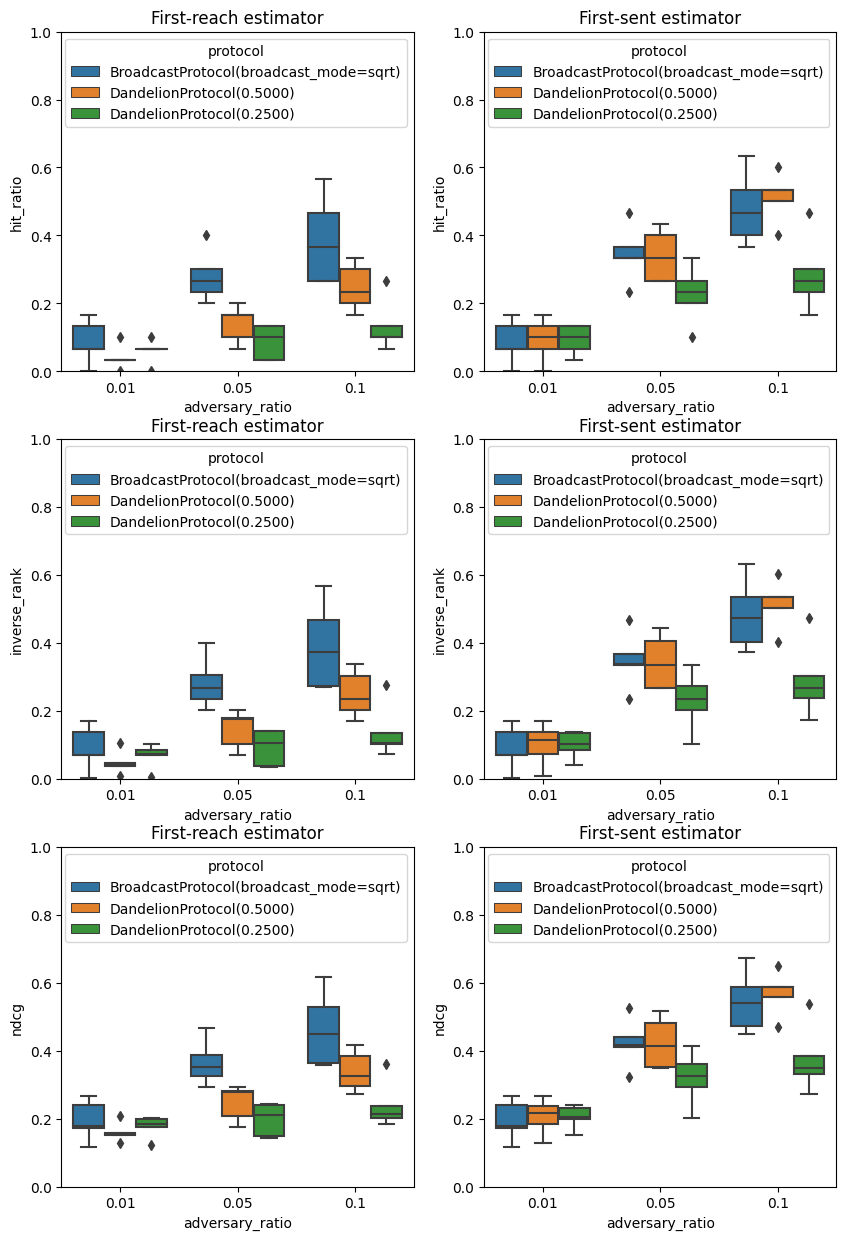

In [17]:
fig, ax = plt.subplots(3,2, figsize=(10,15))
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][0])
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[1][0])
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[2][0])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][1])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[1][1])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[2][1])
for i in range(3):
    for j in range(2):
        ax[i][j].set_title("First-reach estimator" if j % 2 == 0 else "First-sent estimator")
        ax[i][j].set_ylim(0,1.0)

While the fraction of nodes reached by messages are the same range for all protocols

<AxesSubplot: xlabel='adversary_ratio', ylabel='message_spread_ratio'>

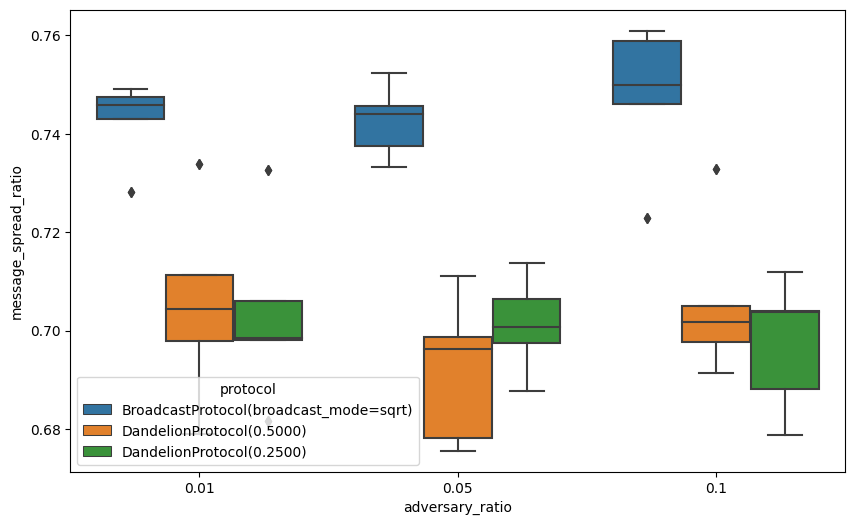

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxplot(data=results_df, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)